In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division, print_function, absolute_import
from tf_utils import load_features, random_mini_batches

train_data, test_data, train_labels, test_labels = load_features()
train_data = train_data.astype(np.float32)
test_data = test_data.astype(np.float32)

In [23]:
#Seeding
seed = 3  
    
#Parameters
learning_rate = 0.001
num_epochs = 100
minibatch_size = 64
display_step = 10

# Network Parameters
num_input = 3584 # 128*28
num_classes = 2
dropout = 0.50

# tf Graph input
X = tf.placeholder(tf.float32, [None, 128, 28])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

In [24]:
# Model
def sound_net(x, weights, biases, dropout):
    # Input Layer
    x = tf.reshape(x, shape=[-1, 128, 28, 1])

    # Convolutional Layer #1
    #input shape [batch, 128, 28, 1]
    #output shape [batch, 128, 28, 80]   
    conv1 = tf.layers.conv2d(inputs=x, filters=80, kernel_size=[57, 6], padding="same", activation=tf.nn.relu)

    # Pooling Layer #1
    # Input Tensor Shape: [batch_size, 128, 28, 80]
    # Output Tensor Shape: [batch_size, 64, 14, 80]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    #input shape [batch_size, 64, 14, 80]
    #output shape [batch_size, 64, 14, 80]
    conv2 = tf.layers.conv2d(inputs=pool1, filters=80, kernel_size=[1, 3], padding="same", activation=tf.nn.relu)
    
    # Pooling Layer #2
    # Input Tensor Shape: [batch_size, 64, 14, 80]
    # Output Tensor Shape: [batch_size, 8, 2, 80]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[8, 7], strides=[8, 7])

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    dense1 = tf.reshape(pool2, [-1, weights['wd1'].get_shape().as_list()[0]])
    dense1 = tf.add(tf.matmul(dense1, weights['wd1']), biases['bd1'])
    dense1 = tf.nn.relu(dense1)
    # Apply Dropout
#     fc1 = tf.nn.dropout(fc1, dropout)
    
    # Output, class prediction
    out = tf.add(tf.matmul(dense1, weights['out']), biases['out'])
    return out

In [25]:
# Store weights and biases
weights = {
    # 57x6 conv
    'wc1': tf.Variable(tf.random_normal([57, 6, 1, 80])),
    # 1x3 conv
    'wc2': tf.Variable(tf.random_normal([1, 3, 80, 80])),
    # fully connected, 8*2*80 inputs (after maxpool), 1024 outputs
    'wd1': tf.Variable(tf.random_normal([8*2*80, 1024])),
    # 1024 inputs, 2 outputs
    'out': tf.Variable(tf.random_normal([1024, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([80])),
    'bc2': tf.Variable(tf.random_normal([80])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# build model
logits = sound_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize
init = tf.global_variables_initializer()

Cost after epoch 0: 64413.915146
Cost after epoch 10: 1458.771366
Cost after epoch 20: 1686.280954
Cost after epoch 30: 486.052479
Cost after epoch 40: 171.956118
Cost after epoch 50: 103.745027
Cost after epoch 60: 376.417099
Cost after epoch 70: 212.788921
Cost after epoch 80: 209.293725
Cost after epoch 90: 114.754888
Done training! 


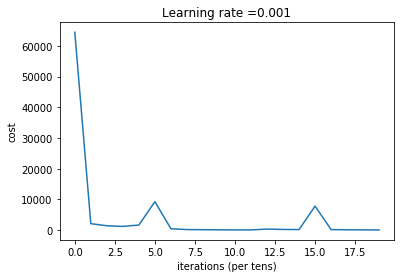

Test Accuracy: 0.7241379


In [26]:
# Training
costs = []
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(num_epochs):
    
        epoch_cost = 0.
        seed = seed + 1
        minibatches = random_mini_batches(train_data, train_labels, minibatch_size, seed)

        for minibatch in minibatches:
            (batch_x, batch_y) = minibatch
            #convert to one_hot for labels
            batch_y = tf.one_hot(batch_y, num_classes)
            batch_y = sess.run(batch_y)
            batch_y = batch_y.reshape((batch_y.shape[0], num_classes))

            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y,
                                                                 keep_prob: 1.0})
            epoch_cost += loss
            
        #After running all minibatches    
        if epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
        if epoch % 5 == 0:
            costs.append(epoch_cost)            
            
    print("Done training! ")
    
    #Plot loss over time
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()    

    # Test accuracy
    test_labels = tf.one_hot(test_labels, num_classes)
    test_labels = sess.run(test_labels)    
    print("Test Accuracy:", \
        sess.run(accuracy, feed_dict={X: test_data,
                                      Y: test_labels,
                                      keep_prob: 1.0}))

In [21]:
tf.reset_default_graph()